## Response Ranking

 

# Preliminaries: Inspect and Set up environment

In [93]:
import datetime
print(datetime.datetime.now())

2025-08-03 18:17:59.337695


In [94]:
import sys
print(sys.executable)


c:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\venv_main\Scripts\python.exe


In [95]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 0. Data Loading and Inspection


# 0.1 Unzip and Load the Data

In [5]:
import zipfile
import py7zr
import pandas as pd
from pathlib import Path

import zipfile
from pathlib import Path

import zipfile
from pathlib import Path
import shutil
zip_path = r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\kkbox-churn-prediction-challenge.zip"


import zipfile
import py7zr
import pandas as pd
from pathlib import Path

def load_csvs_from_zip_of_7z(zip_path_str, temp_dir_str="unzipped_temp"):
    zip_path = Path(zip_path_str)
    temp_dir = Path(temp_dir_str)
    temp_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n📦 Extracting .7z files from ZIP: {zip_path.name}")
    with zipfile.ZipFile(zip_path, 'r') as z:
        for name in z.namelist():
            if name.endswith('.7z'):
                print(f"→ Extracting {name}")
                z.extract(name, path=temp_dir)

    dfs = {}

    print("\n📂 Extracting .csv files from each .7z:")
    for seven_z_path in temp_dir.rglob("*.7z"):
        print(f"→ Unpacking: {seven_z_path.name}")
        inner_extract_dir = seven_z_path.with_suffix("")  # folder with same name
        inner_extract_dir.mkdir(exist_ok=True)

        try:
            with py7zr.SevenZipFile(seven_z_path, mode='r') as archive:
                archive.extractall(path=inner_extract_dir)
        except Exception as e:
            print(f"❌ Failed to extract {seven_z_path.name}: {e}")
            continue

        for csv_file in inner_extract_dir.glob("*.csv"):
            try:
                df = pd.read_csv(csv_file)
                key = csv_file.stem.lower()  # use file name without extension as key
                dfs[key] = df
                print(f"✓ Loaded {csv_file.name}, shape: {df.shape}")
            except Exception as e:
                print(f"⚠️ Failed to read {csv_file.name}: {e}")

    if not dfs:
        print("⚠️ No CSVs loaded. Check if the ZIP contains .7z files and they contain .csv files.")
    else:
        print(f"\n✅ Loaded {len(dfs)} CSV file(s): {list(dfs.keys())}")

    return dfs





In [ ]:
# dfs = load_csvs_from_zip_of_7z(
#     zip_path_str=r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\kkbox-churn-prediction-challenge.zip",
#     temp_dir_str=r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\data"
# )



📦 Extracting .7z files from ZIP: kkbox-churn-prediction-challenge.zip
→ Extracting members_v3.csv.7z
→ Extracting sample_submission_v2.csv.7z
→ Extracting sample_submission_zero.csv.7z
→ Extracting train.csv.7z
→ Extracting train_v2.csv.7z
→ Extracting transactions.csv.7z
→ Extracting transactions_v2.csv.7z
→ Extracting user_logs.csv.7z
→ Extracting user_logs_v2.csv.7z

📂 Extracting .csv files from each .7z:
→ Unpacking: members_v3.csv.7z
✓ Loaded members_v3.csv, shape: (6769473, 6)
→ Unpacking: sample_submission_v2.csv.7z
→ Unpacking: sample_submission_zero.csv.7z
✓ Loaded sample_submission_zero.csv, shape: (970960, 2)
→ Unpacking: train.csv.7z
✓ Loaded train.csv, shape: (992931, 2)
→ Unpacking: train_v2.csv.7z
→ Unpacking: transactions.csv.7z
✓ Loaded transactions.csv, shape: (21547746, 9)
→ Unpacking: transactions_v2.csv.7z
→ Unpacking: user_logs.csv.7z
✓ Loaded user_logs.csv, shape: (392106543, 9)
→ Unpacking: user_logs_v2.csv.7z

✅ Loaded 5 CSV file(s): ['members_v3', 'sample_sub

# 1.1 Load data 

In [135]:
df_train=pd.read_csv(r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\unzipped_temp\train_v2.csv\data\churn_comp_refresh\train_v2.csv")
df_transactions=pd.read_csv(r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\unzipped_temp\transactions_v2.csv\data\churn_comp_refresh\transactions_v2.csv")
df_member=pd.read_csv(r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\unzipped_temp\members_v3.csv\members_v3.csv")      
df_user_logs=pd.read_csv(r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\unzipped_temp\user_logs_v2.csv\data\churn_comp_refresh\user_logs_v2.csv")

# 1.2  Aggregate User Behavior Logs Before Campaign Response




In [136]:
import pandas as pd


 
def prepare_training_data(df_transactions, df_train, df_user_logs, top_n=10):
    # Step 1: Get Top-N most frequent campaign combinations
    top_campaigns = (
        df_transactions
        .groupby([ 'payment_plan_days', 'plan_list_price'])
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
        .head(top_n)
    )
    top_campaigns['campaign_id'] = ['C' + str(i + 1) for i in range(len(top_campaigns))]

    # Step 2: Filter transactions to only those Top-N campaigns
    df_top = df_transactions.merge(
        top_campaigns.drop(columns='count'),
        on=[ 'payment_plan_days', 'plan_list_price'],
        how='inner'
    )

    # Step 3: Add churn label 
    df_top['transaction_date'] = pd.to_datetime(
    df_top['transaction_date'],
    format='%Y%m%d' # adjust if format is different
)
    

    df_top = df_top.sort_values(by=['msno', 'transaction_date'])
    df_top['payment_plan_days'] = df_top['payment_plan_days'].astype(int)

    # 2. add information about next transaction
    df_top['next_transaction_date'] = df_top.groupby('msno')['transaction_date'].shift(-1)
    df_top['next_plan_days'] = df_top.groupby('msno')['payment_plan_days'].shift(-1)
    df_top['next_price'] = df_top.groupby('msno')['plan_list_price'].shift(-1)

    # 3. varify if it si renew in same plan
    df_top['same_plan'] = (
        (df_top['payment_plan_days'] == df_top['next_plan_days']) &
        (df_top['plan_list_price'] == df_top['next_price'])
    )

    # 4. no matter what, if next transaction date is within 5 days of current transaction date, it is considered a renewal
    # no matter the customer churn or cancel eventually, we only focus on if they renew in this time window becuase we will do pairwise ranking  
    df_top['renew_any'] = (
        (df_top['next_transaction_date'] - df_top['transaction_date']).dt.days <= df_top['payment_plan_days']+5
    ).astype(int)

    # # 5. 严格版：续订时间在有效期内，且 plan 一致
    # df_top['renew_strict'] = (
    #     df_top['renew_any'].astype(bool) & df_top['same_plan']
    # ).astype(int)




    # Step 5: Prepare user logs
    df_user_logs['date'] = pd.to_datetime(df_user_logs['date'], format='%Y%m%d')
    df_top['transaction_date'] = pd.to_datetime(df_top['transaction_date'], format='%Y%m%d')

    # Step 6: Join logs with transactions
    logs_matched = df_user_logs.merge(
        df_top[['msno', 'campaign_id', 'transaction_date','next_transaction_date']],
        on='msno',
        how='inner'
    )

    # Step 7: Keep only logs BEFORE transaction date (if next transaction date is NaN then find the behavior after transaction ; if next transaction is not null then  find behavoir BETWEEN transaction date and next transaction date)
    logs_matched = logs_matched[
    (
        logs_matched['next_transaction_date'].isna() & 
         (logs_matched['date'] >= logs_matched['transaction_date'])
    )
    |
    (
        logs_matched['next_transaction_date'].notna() & 
        (logs_matched['date'] >= logs_matched['transaction_date']) &
        (logs_matched['date'] < logs_matched['next_transaction_date'])
    )
]

    # Step 8: Aggregate log features
    user_features = logs_matched.groupby(['msno', 'transaction_date','campaign_id']).agg({
        'num_25': 'sum',
        'num_50': 'sum',
        'num_75': 'sum',
        'num_985': 'sum',
        'num_100': 'sum',
        'num_unq': 'mean',
        'total_secs': 'mean'
    }).reset_index()

    #Step 9: Final dataset = df_top + user behavior
    df_final = df_top.merge(user_features, on=['msno', 'campaign_id','transaction_date'], how='left')

    return df_final


In [137]:
df_model = prepare_training_data(df_transactions, df_train, df_user_logs, top_n=3)

In [138]:
df_model

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,campaign_id,...,next_price,same_plan,renew_any,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,2017-03-15,20170415,0,C2,...,NaN,False,0,115.0,53.0,49.0,91.0,364.0,30.647059,7022.562294
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,1,2017-02-28,20170419,0,C1,...,149.0,True,1,43.0,12.0,15.0,12.0,480.0,17.148148,4226.819556
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,1,2017-03-31,20170519,0,C1,...,NaN,False,0,0.0,0.0,0.0,0.0,5.0,5.000000,1287.132000
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149,149,1,2017-03-26,20170426,0,C1,...,NaN,False,0,17.0,5.0,4.0,4.0,28.0,13.000000,2863.600667
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41,30,149,149,1,2017-03-15,20170415,0,C1,...,NaN,False,0,79.0,15.0,23.0,18.0,228.0,9.562500,3978.025250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117660,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,36,30,180,180,0,2017-02-28,20170401,0,C3,...,NaN,False,0,136.0,69.0,46.0,61.0,1125.0,16.548387,8646.443968
1117661,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,29,30,180,180,0,2017-03-11,20170410,0,C3,...,NaN,False,0,17.0,8.0,7.0,6.0,2116.0,99.437500,29865.424312
1117662,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,20170424,0,C1,...,149.0,True,1,30.0,9.0,12.0,10.0,215.0,12.368421,3136.191579
1117663,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-03-31,20170524,0,C1,...,NaN,False,0,3.0,1.0,0.0,0.0,4.0,5.000000,1366.085000


In [139]:
#df_model[df_model["msno"]=='+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=']
df_model[df_model["msno"]=='zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=']

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,campaign_id,...,next_price,same_plan,renew_any,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1117662,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,20170424,0,C1,...,149.0,True,1,30.0,9.0,12.0,10.0,215.0,12.368421,3136.191579
1117663,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-03-31,20170524,0,C1,...,NaN,False,0,3.0,1.0,0.0,0.0,4.0,5.000000,1366.085000


In [109]:
df_model.columns

Index(['msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel', 'campaign_id',
       'next_transaction_date', 'next_plan_days', 'next_price', 'same_plan',
       'renew_any', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
       'num_unq', 'total_secs'],
      dtype='object')

# STEP 2 EDA 

In [110]:
df_model
target_feature = 'renew_any'

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,campaign_id,...,next_price,same_plan,renew_any,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,2017-03-15,20170415,0,C2,...,NaN,False,0,115.0,53.0,49.0,91.0,364.0,30.647059,7022.562294
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,1,2017-02-28,20170419,0,C1,...,149.0,True,1,43.0,12.0,15.0,12.0,480.0,17.148148,4226.819556
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,1,2017-03-31,20170519,0,C1,...,NaN,False,0,0.0,0.0,0.0,0.0,5.0,5.000000,1287.132000
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149,149,1,2017-03-26,20170426,0,C1,...,NaN,False,0,17.0,5.0,4.0,4.0,28.0,13.000000,2863.600667
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41,30,149,149,1,2017-03-15,20170415,0,C1,...,NaN,False,0,79.0,15.0,23.0,18.0,228.0,9.562500,3978.025250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117660,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,36,30,180,180,0,2017-02-28,20170401,0,C3,...,NaN,False,0,136.0,69.0,46.0,61.0,1125.0,16.548387,8646.443968
1117661,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,29,30,180,180,0,2017-03-11,20170410,0,C3,...,NaN,False,0,17.0,8.0,7.0,6.0,2116.0,99.437500,29865.424312
1117662,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,20170424,0,C1,...,149.0,True,1,30.0,9.0,12.0,10.0,215.0,12.368421,3136.191579
1117663,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-03-31,20170524,0,C1,...,NaN,False,0,3.0,1.0,0.0,0.0,4.0,5.000000,1366.085000


In [111]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117665 entries, 0 to 1117664
Data columns (total 22 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   msno                    1117665 non-null  object        
 1   payment_method_id       1117665 non-null  int64         
 2   payment_plan_days       1117665 non-null  int64         
 3   plan_list_price         1117665 non-null  int64         
 4   actual_amount_paid      1117665 non-null  int64         
 5   is_auto_renew           1117665 non-null  int64         
 6   transaction_date        1117665 non-null  datetime64[ns]
 7   membership_expire_date  1117665 non-null  int64         
 8   is_cancel               1117665 non-null  int64         
 9   campaign_id             1117665 non-null  object        
 10  next_transaction_date   184072 non-null   datetime64[ns]
 11  next_plan_days          184072 non-null   float64       
 12  next_price    

In [112]:
df_model.describe().T

,count,mean,min,25%,50%,75%,max,std
payment_method_id,1117665.0,39.001186,10.0,38.0,41.0,41.0,41.0,3.376683
payment_plan_days,1117665.0,30.0,30.0,30.0,30.0,30.0,30.0,0.0
plan_list_price,1117665.0,133.9657,99.0,99.0,149.0,149.0,180.0,28.025716
actual_amount_paid,1117665.0,133.057912,0.0,99.0,149.0,149.0,180.0,29.362555
is_auto_renew,1117665.0,0.91681,0.0,1.0,1.0,1.0,1.0,0.27617
transaction_date,1117665,2017-02-11 00:19:27.677255424,2015-01-01 00:00:00,2017-03-04 00:00:00,2017-03-14 00:00:00,2017-03-25 00:00:00,2017-03-31 00:00:00,NaN
membership_expire_date,1117665.0,20170784.737105,20160419.0,20170408.0,20170418.0,20170429.0,20281206.0,2565.620391
is_cancel,1117665.0,0.029469,0.0,0.0,0.0,0.0,1.0,0.169118
next_transaction_date,184072,2016-09-30 00:16:48.231561216,2015-01-01 00:00:00,2015-12-01 00:00:00,2017-03-24 00:00:00,2017-03-31 00:00:00,2017-03-31 00:00:00,NaN
next_plan_days,184072.0,30.0,30.0,30.0,30.0,30.0,30.0,0.0


In [113]:
df_model.describe(include=object).T

,count,unique,top,freq
msno,1117665,933593,Cb4XS2qU2qnJ5f5iUaWIGOnVf1QWDtq1gYBZ9CRs8yU=,63
campaign_id,1117665,3,C1,594296


In [114]:
# How much missing data is in each feature?

df_model.isna().sum()

msno                           0
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
campaign_id                    0
next_transaction_date     933593
next_plan_days            933593
next_price                933593
same_plan                      0
renew_any                      0
num_25                    381180
num_50                    381180
num_75                    381180
num_985                   381180
num_100                   381180
num_unq                   381180
total_secs                381180
dtype: int64

Taking a look at the class imbalance of our target

No response: 938607
Has response: 179058
training_data_pos_scale_weight: 5.241916027209061


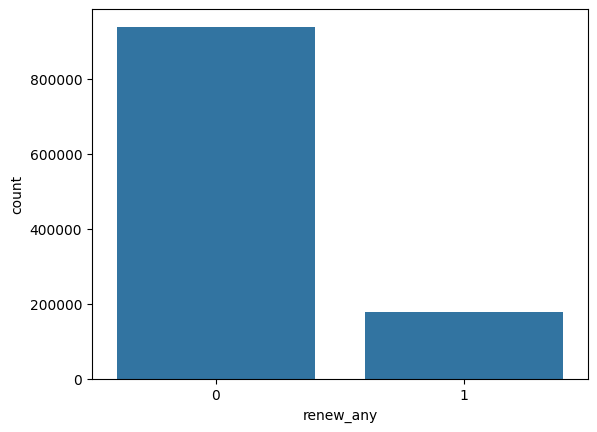

In [115]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

def get_target_skew_rate(data_target):
    target_df = pd.DataFrame(data_target)
    sns.countplot(x=target_feature, data=target_df)

    no_renew_count = len(target_df[target_df[target_feature]==0])
    yes_renew_count = len(target_df[target_df[target_feature]==1])
    print(f"No response: {no_renew_count}")
    print(f"Has response: {yes_renew_count}")

    # save this for later...
    training_data_pos_scale_weight = (no_renew_count / yes_renew_count)
    print(f"training_data_pos_scale_weight: {training_data_pos_scale_weight}")
    return training_data_pos_scale_weight

training_data_pos_scale_weight = get_target_skew_rate(df_model[target_feature])

In [116]:
df_model.dtypes

msno                              object
payment_method_id                  int64
payment_plan_days                  int64
plan_list_price                    int64
actual_amount_paid                 int64
is_auto_renew                      int64
transaction_date          datetime64[ns]
membership_expire_date             int64
is_cancel                          int64
campaign_id                       object
next_transaction_date     datetime64[ns]
next_plan_days                   float64
next_price                       float64
same_plan                           bool
renew_any                          int64
num_25                           float64
num_50                           float64
num_75                           float64
num_985                          float64
num_100                          float64
num_unq                          float64
total_secs                       float64
dtype: object

<Axes: >

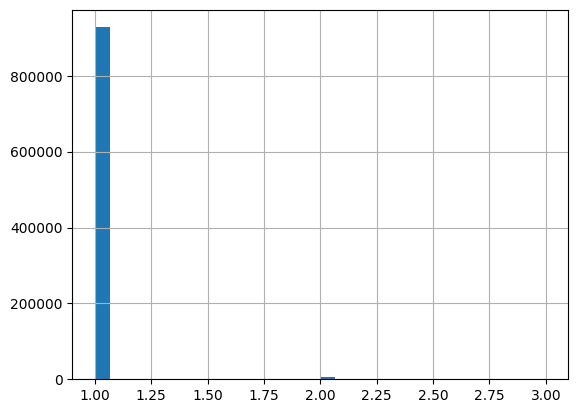

In [117]:
user_campaign_count = df_model.groupby('msno')['campaign_id'].nunique()
user_campaign_count.hist(bins=30)


<Axes: xlabel='campaign_id'>

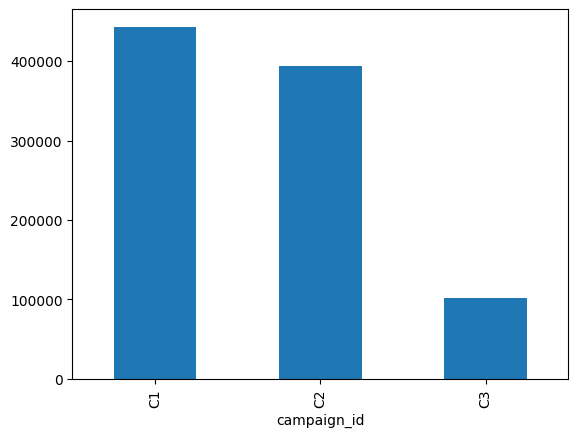

In [118]:
campaign_user_count = df_model.groupby('campaign_id')['msno'].nunique()
campaign_user_count.sort_values(ascending=False).head(10).plot(kind='bar')


<Axes: xlabel='campaign_id'>

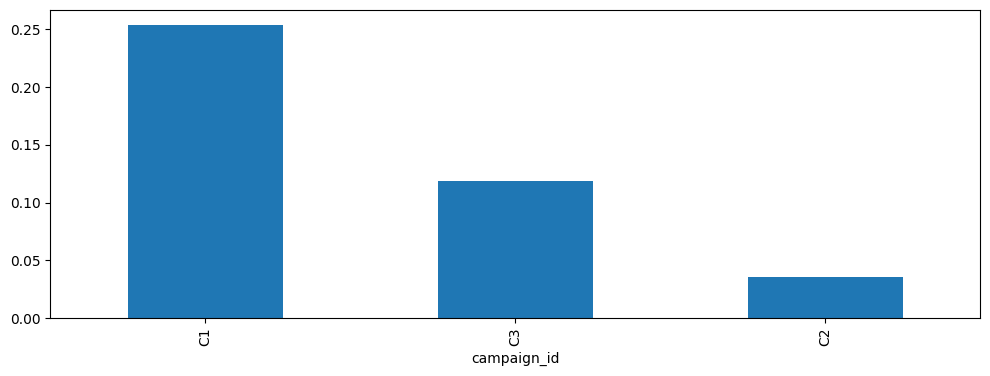

In [119]:
campaign_response_rate = df_model.groupby('campaign_id')['renew_any'].mean().sort_values(ascending=False)
campaign_response_rate.plot(kind='bar', figsize=(12,4))


In [68]:
# category columns and number columns
numerical_cols = df_model.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
categorical_cols = df_model.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()  

categorical_cols

['msno', 'campaign_id', 'same_plan']

# 2. 1 Build Negative Samples

In [160]:
def generate_negative_samples(
    df, 
    campaign_pool,
    behavior_cols,
    campaign_features_df=None,
    campaign_key='campaign_id',
    msno_key='msno',
    n=2,
    random_state=42
):
    """
    为每个用户生成 n 个负样本（未曾订阅的 campaign），行为特征设为 0。
    
    参数:
    - df: 包含正样本的 DataFrame
    - campaign_pool: 所有可选 campaign_id 列表（如 df_model['campaign_id'].unique()）
    - behavior_cols: 用户行为特征列（如 num_25, num_100 等）
    - campaign_features_df: campaign 特征表（如 plan_days, list_price 等）
    - campaign_key: campaign 列名（默认 'campaign_id'）
    - msno_key: 用户列名（默认 'msno'）
    - n: 每个用户生成负样本数量
    """
    
    np.random.seed(random_state)
    df_negatives = []

    for user, group in df.groupby(msno_key):
        used_campaigns = set(group[campaign_key])
        negative_candidates = list(set(campaign_pool) - used_campaigns)

        if not negative_candidates:
            continue

        sampled_neg = np.random.choice(negative_candidates, size=min(n, len(negative_candidates)), replace=False)

        for campaign in sampled_neg:
            # 随机复制该用户一条正样本行为
            base_row = group.sample(1).iloc[0].copy()
            base_row[campaign_key] = campaign
            base_row['renew_any'] = 0
            base_row['is_auto_renew'] = 0  # 或者保留原值

            # 所有行为特征设为 0
            for col in behavior_cols:
                if col in base_row:
                    base_row[col] = 0

            df_negatives.append(base_row)

    df_neg = pd.DataFrame(df_negatives)

    # ⚠️ 加回 campaign 特征（通过 merge）
    if campaign_features_df is not None:
        # 先 drop 掉已有的 campaign 特征列
        drop_cols = [col for col in campaign_features_df.columns if col != campaign_key]
        df_neg = df_neg.drop(columns=drop_cols, errors='ignore')

        df_neg = df_neg.merge(campaign_features_df, on=campaign_key, how='left')

    # 合并正负样本
    df_all = pd.concat([df, df_neg], ignore_index=True)

    return df_all


In [161]:
campaign_pool = df_model['campaign_id'].unique()
behavior_cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

campaign_features_df = df_model[['campaign_id', 'payment_plan_days', 'plan_list_price']].drop_duplicates()

df_model_augmented = generate_negative_samples(
    df=df_model,
    campaign_pool=campaign_pool,
    behavior_cols=behavior_cols,
    campaign_features_df=campaign_features_df
)


In [162]:
df_model_augmented[df_model_augmented["msno"]=='zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=']

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,campaign_id,...,next_price,same_plan,renew_any,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1117662,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-02-28,20170424,0,C1,...,149.0,True,1,30.0,9.0,12.0,10.0,215.0,12.368421,3136.191579
1117663,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,149,149,1,2017-03-31,20170524,0,C1,...,NaN,False,0,3.0,1.0,0.0,0.0,4.0,5.000000,1366.085000
2979192,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,99,149,0,2017-03-31,20170524,0,C2,...,NaN,False,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2979193,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,39,30,180,149,0,2017-02-28,20170424,0,C3,...,149.0,True,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


CHECK the distribution after add negative samples

No response: 2800138
Has response: 179058
training_data_pos_scale_weight: 15.638161936355818


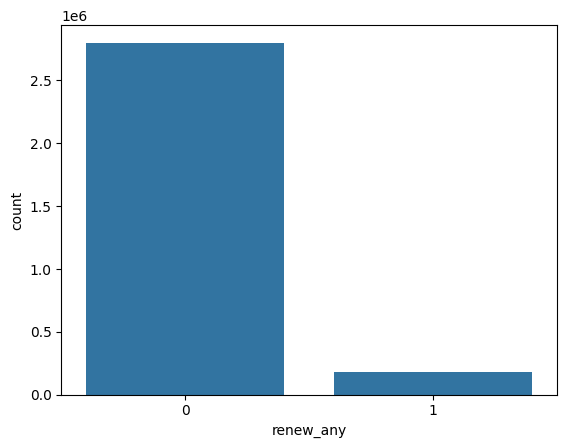

In [163]:
training_data_pos_scale_weight = get_target_skew_rate(df_model_augmented[target_feature])

<Axes: >

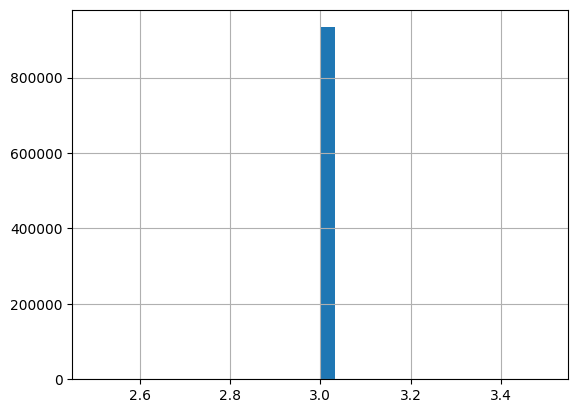

In [164]:
user_campaign_count = df_model_augmented.groupby('msno')['campaign_id'].nunique()
user_campaign_count.hist(bins=30)


<Axes: xlabel='campaign_id'>

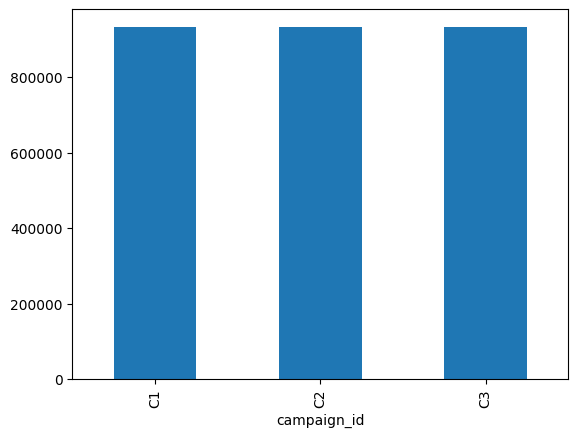

In [165]:
campaign_user_count = df_model_augmented.groupby('campaign_id')['msno'].nunique()
campaign_user_count.sort_values(ascending=False).head(10).plot(kind='bar')


# 3. Preprocessing

3.1 drop columns

3.2 imputation : fill 0 in the NA value

3.3 transformation : standardization +label encoding 

3.4 feature engineering dont have it this time

In [174]:
from sklearn.preprocessing import LabelEncoder

def preprocess_pipeline(df, behavior_cols, user_col='msno'):
    """
    对 campaign 响应模型进行数据预处理，包括：
    1. 删除不需要的列
    2. 填补用户行为特征缺失值（基于用户均值）
    3. 编码分类变量（如 payment_method_id）

    参数：
    - df: 原始 DataFrame
    - behavior_cols: 用户行为特征列名（如 ['num_25', 'num_50', ...]）
    - user_col: 用户标识列（默认 'msno'）

    返回：
    - 预处理后的 DataFrame
    """
    df = df.copy()

    # 1. 删除不需要的列
    drop_cols = [
        'transaction_date',
        'next_transaction_date',
        'membership_expire_date',
        'actual_amount_paid',
        'is_cancel',
        'is_churn',
        'next_plan_days',
        'next_price',
        'same_plan',
        'campaign_id'
    ]
    df.drop(columns=drop_cols, errors='ignore', inplace=True)

    # 2. 用户行为特征缺失填补（先按用户均值，再用0填）
    for col in behavior_cols:
        if col in df.columns:
            user_means = df.groupby(user_col)[col].transform('mean')
            df[col] = df[col].fillna(user_means)
            df[col] = df[col].fillna(0)

    # 3. Label encode payment_method_id（如果存在）
    if 'payment_method_id' in df.columns:
        le = LabelEncoder()
        df['payment_method_id'] = le.fit_transform(df['payment_method_id'].astype(str))

    return df


In [175]:
df= preprocess_pipeline(df_model_augmented, behavior_cols, user_col='msno')

In [169]:
df[df["msno"]=='zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=']

,msno,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,campaign_id,renew_any,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1117662,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,18,30,149,1,C1,1,30.0,9.0,12.0,10.0,215.0,12.368421,3136.191579
1117663,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,18,30,149,1,C1,0,3.0,1.0,0.0,0.0,4.0,5.000000,1366.085000
2979192,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,18,30,99,0,C2,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2979193,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,18,30,180,0,C3,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [170]:

df.isna().sum()

msno                 0
payment_method_id    0
payment_plan_days    0
plan_list_price      0
is_auto_renew        0
campaign_id          0
renew_any            0
num_25               0
num_50               0
num_75               0
num_985              0
num_100              0
num_unq              0
total_secs           0
dtype: int64

# step 4 Fit into Model

In [171]:
import lightgbm
print(lightgbm.__version__)

4.6.0


In [179]:
from itertools import product
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRanker
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.metrics import ndcg_score
import numpy as np

# 参数网格
param_grid = {
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 63],
    'min_data_in_leaf': [20, 50]
}

# 所有参数组合
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# 准备数据
df = df_model_augmented.copy()
behavior_cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
label_col = 'renew_any'
group_col = 'msno'

# GroupKFold 初始化
gkf = GroupKFold(n_splits=3)

results = []

for param_values in param_combinations:
    param_dict = dict(zip(param_names, param_values))
    print(f"\nTesting parameters: {param_dict}")
    
    ndcg_scores = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(df, df[label_col], df[group_col])):
        train_df = df.iloc[train_idx].copy()
        val_df = df.iloc[val_idx].copy()

        # 预处理
        train_df = preprocess_pipeline(train_df, behavior_cols, user_col='msno')
        val_df = preprocess_pipeline(val_df, behavior_cols, user_col='msno')

        # 准备 X, y, group
        def prepare_X_y_group(df, label_col='renew_any'):
            X = df.drop(columns=[label_col, 'msno'], errors='ignore')
            y = df[label_col]
            group = df.groupby('msno').size().to_numpy()
            return X, y, group

        X_train, y_train, group_train = prepare_X_y_group(train_df)
        X_val, y_val, group_val = prepare_X_y_group(val_df)

        # 模型训练
        model = LGBMRanker(
            objective='lambdarank',
            metric='ndcg',
            n_estimators=300,
            random_state=42,
            **param_dict
        )

        model.fit(
            X_train, y_train,
            group=group_train,
            eval_set=[(X_val, y_val)],
            eval_group=[group_val],
            callbacks=[
                early_stopping(stopping_rounds=20, verbose=False)
            ]
        )

        # 验证集预测并评估 NDCG@3
        preds = model.predict(X_val)
        ndcg = ndcg_score([y_val], [preds], k=3)
        ndcg_scores.append(ndcg)

    avg_ndcg = np.mean(ndcg_scores)
    print(f"Average NDCG@3: {avg_ndcg:.4f}")
    results.append((param_dict, avg_ndcg))

# 找出最佳参数
best_params, best_score = max(results, key=lambda x: x[1])
print("\nBest Parameters:", best_params)
print("Best NDCG@3 Score:", best_score)



Testing parameters: {'learning_rate': 0.05, 'num_leaves': 31, 'min_data_in_leaf': 20}
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 1986132, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Average NDCG@3: 0.0395

Testing parameters: {'learning_rate': 0.05, 'num_leaves': 31, 'min_data_in_leaf': 50}
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 1986132, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Average NDCG@3: 0.0395

Testing parameters: {'learning_rate': 0.05, 'num_leaves': 63, 'min_data_in_leaf': 20}
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 1986132, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Average NDCG@3: 0.0422

Testing parameters: {'learning_rate': 0.05, 'num_leaves': 63, 'min_data_in_leaf': 50}
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 1986132, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Average NDCG@3: 0.0422

Testing parameters: {'learning_rate': 0.1, 'num_leaves': 31, 'min_data_in_leaf': 20}
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 1986132, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Average NDCG@3: 0.0288

Testing parameters: {'learning_rate': 0.1, 'num_leaves': 31, 'min_data_in_leaf': 50}
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 1986132, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Average NDCG@3: 0.0288

Testing parameters: {'learning_rate': 0.1, 'num_leaves': 63, 'min_data_in_leaf': 20}
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 1986132, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Average NDCG@3: 0.0325

Testing parameters: {'learning_rate': 0.1, 'num_leaves': 63, 'min_data_in_leaf': 50}
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 1986132, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Average NDCG@3: 0.0322

Best Parameters: {'learning_rate': 0.05, 'num_leaves': 63, 'min_data_in_leaf': 20}
Best NDCG@3 Score: 0.0422420803480928


# Step 5: Best Parameter +Final Model+ Feature Selection

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1795
[LightGBM] [Info] Number of data points in the train set: 2979196, number of used features: 10


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 11 artists>

([<matplotlib.axis.YTick at 0x201ea4f1590>,
 [Text(0, 0, 'num_100'),
  Text(0, 1, 'total_secs'),
  Text(0, 2, 'payment_method_id'),
  Text(0, 3, 'num_unq'),
  Text(0, 4, 'num_75'),
  Text(0, 5, 'num_50'),
  Text(0, 6, 'num_985'),
  Text(0, 7, 'num_25'),
  Text(0, 8, 'plan_list_price'),
  Text(0, 9, 'is_auto_renew'),
  Text(0, 10, 'payment_plan_days')])

Text(0.5, 0, 'Feature Importance')

Text(0.5, 1.0, 'Top 20 Feature Importances')

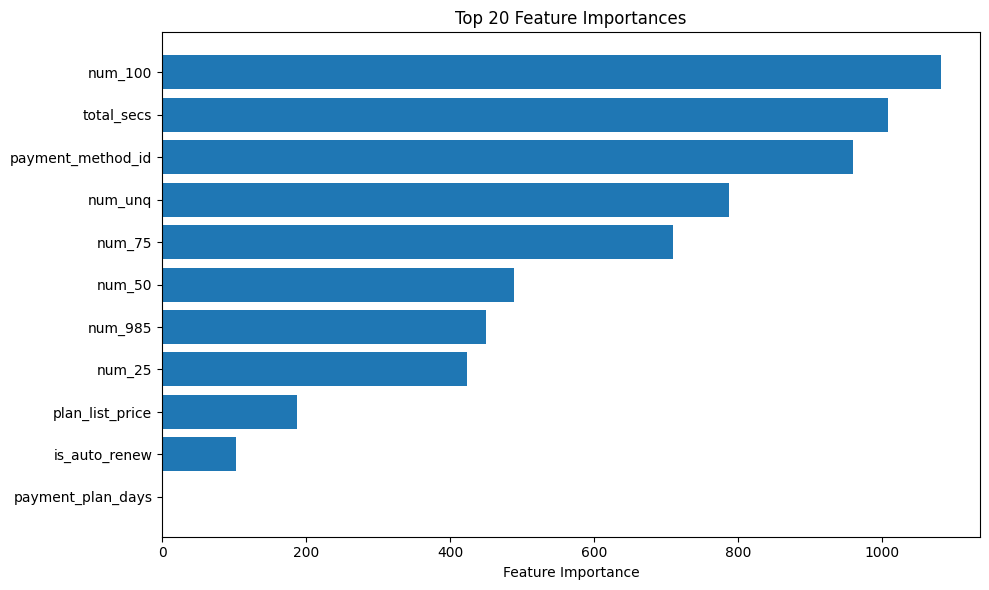

In [181]:

# 🔁 用所有训练好的 df_model_augmented 拟合最终模型
# 1. 预处理
behavior_cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
df_final = preprocess_pipeline(df_model_augmented.copy(), behavior_cols, user_col='msno')

# 2. 准备 X, y, group
def prepare_X_y_group(df, label_col='renew_any'):
    X = df.drop(columns=[label_col, 'msno'], errors='ignore')
    y = df[label_col]
    group = df.groupby('msno').size().to_numpy()
    return X, y, group

X_final, y_final, group_final = prepare_X_y_group(df_final)

# 3. 拟合模型
final_model = LGBMRanker(**best_params)
final_model.fit(X_final, y_final, group=group_final)

# 4. 展示特征重要性
importances = final_model.feature_importances_
feature_names = X_final.columns

# 排序显示前 20 个重要特征
sorted_idx = importances.argsort()[::-1][:20]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Step 6: Feature Importance

In [187]:
import pandas as pd
import numpy as np

# 获取特征重要性并排序
selected_features = X_train.columns.tolist()
feature_importances = pd.Series(final_model.feature_importances_, index=selected_features)

sorted_features = feature_importances.sort_values(ascending=False)

# 只选前 N 个特征（例如 10 个）
top_k = 5
selected_features = sorted_features.head(top_k).index.tolist()
print("Top features:\n", selected_features)

 
X_final, y_final, group_final = prepare_X_y_group(df_final)
 

X_selected = X_final[selected_features]
y_selected = y_final
group_selected = group_final

 

model.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],        # ✅ 验证集
    eval_group=[group_val],           # ✅ 验证集对应的 group 信息
    eval_metric='ndcg',               # ✅ 明确指定评估指标
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(period=10)
    ]
)





Top features:
 ['num_100', 'total_secs', 'payment_method_id', 'num_unq', 'num_75']
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 1986130, number of used features: 10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Training until validation scores don't improve for 20 rounds
[10]	valid_0's ndcg@1: 0.920369	valid_0's ndcg@2: 0.951023	valid_0's ndcg@3: 0.964989	valid_0's ndcg@4: 0.966049	valid_0's ndcg@5: 0.96

,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20
